In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit import BasicAer

In [2]:
def execute_circuit(circuit, backend=Aer.get_backend('qasm_simulator'), shots=1024):
    job = execute(circuit, backend=backend, shots=shots)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def count_to_prob(counts, num_qubits=None):
    shots = sum(counts.values())
    n_qubits = num_qubits if num_qubits is not None else len(list(counts.keys())[0])

    probs = np.zeros(2**n_qubits)
    for key, value in counts.items():
        index = int(key, 2) if type(key) == str else key
        probs[index] = value/shots
    return probs

def get_statevector(circuit, backend=Aer.get_backend('statevector_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    statevector = result.get_statevector(circuit)
    return statevector

def get_unitary(circuit, backend=Aer.get_backend('unitary_simulator')):
    job = execute(circuit, backend=backend)
    result = job.result()
    unitary = result.get_unitary(circuit)
    return unitary

# Variational Quantum Classifier

Problem: Given a set of data points, we want to classify them into two classes. We can use a quantum circuit to do this classification.

## Dataset

The dataset we will use is the Iris dataset. This dataset contains 150 data points, each with 4 features. Each data point is labeled as one of three classes: Iris Setosa, Iris Versicolour, and Iris Virginica. We will only use two classes, Iris Setosa and Iris Versicolour. We will label Iris Setosa as 0 and Iris Versicolour as 1.

### Iris Setosa
<img  src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width="200px" height="200px" />



### Iris Versicolour
<img  src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width="200px" height="200px" />

In [3]:
iris_data = pd.read_csv('iris_dataset.csv', header=None)
iris_data.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Prepare the labels
iris_data[4] = iris_data[4].map({'Iris-setosa': 0, 'Iris-versicolor': 1})
iris_data.describe()

,0,1,2,3,4
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,5.471000,3.094000,2.862000,0.785000,0.500000
std,0.641698,0.476057,1.448565,0.566288,0.502519
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.000000,2.800000,1.500000,0.200000,0.000000
50%,5.400000,3.050000,2.450000,0.800000,0.500000
75%,5.900000,3.400000,4.325000,1.300000,1.000000
max,7.000000,4.400000,5.100000,1.800000,1.000000


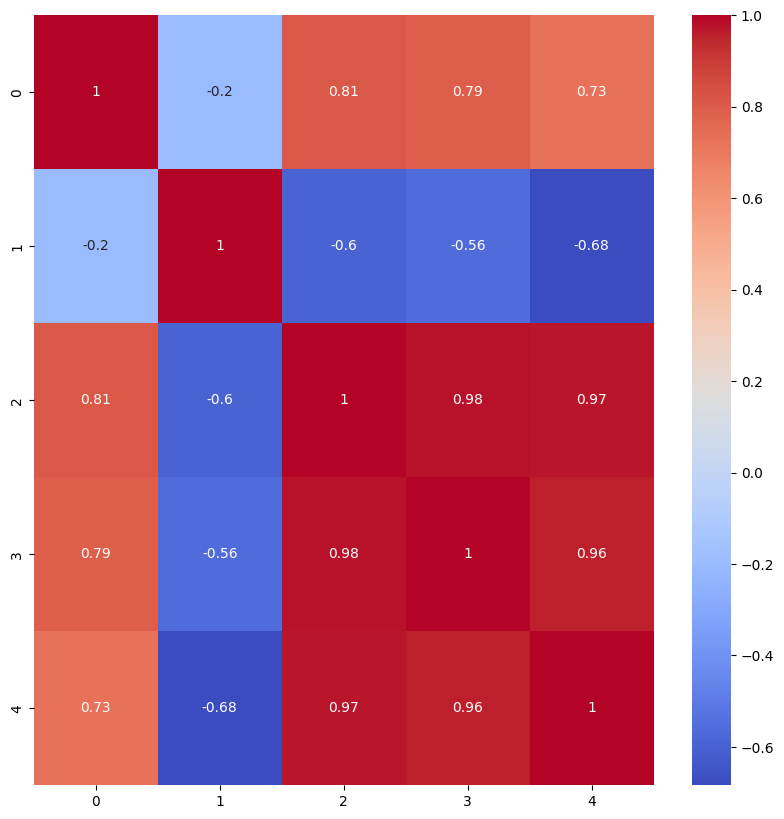

In [6]:
# Heatmap
plt.figure(figsize=(10,10))
sns.heatmap(iris_data.corr(), annot=True, cmap='coolwarm')
plt.show()

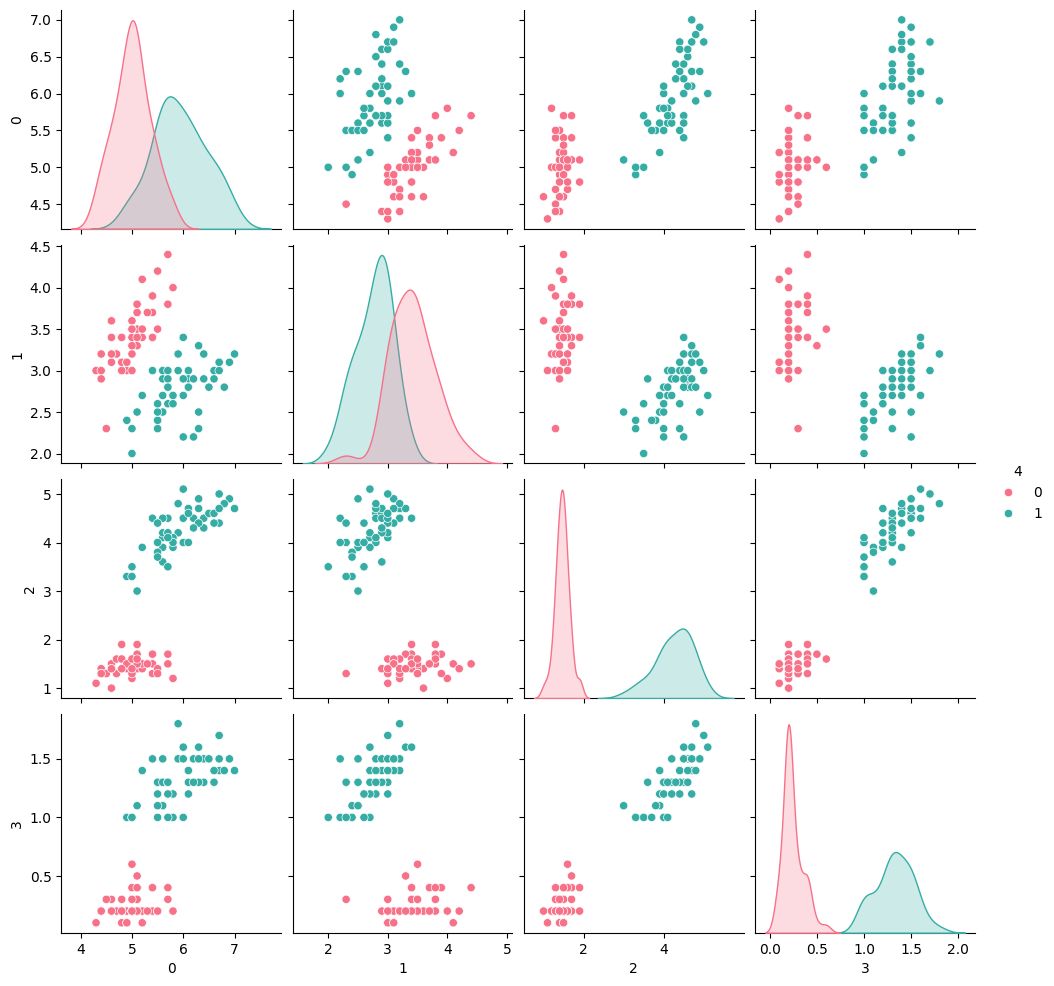

In [7]:
# Plot pairplot

sns.pairplot(iris_data, hue=4, palette='husl')
plt.show()

It is posible to see that the classification process can be easily done by using only the features 2 and 3. So, we will only use these two features.

In [11]:
iris_data_two_features = iris_data.iloc[:, [2, 3, 4]]

Separate the data into training and test sets.

In [16]:
# Separate the data into training and testing
from sklearn.model_selection import train_test_split

X = iris_data_two_features.iloc[:, [0, 1]].values
y = iris_data_two_features.iloc[:, 2].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (80, 2)
X_test shape: (20, 2)


### Classical Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [21]:
# Random Forest Classifier

rf_classifier = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
# Accuracy
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 1.0


### Quantum Variational Classifier

In [144]:
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal

### Normalization

The normalization of the data is done due to the fact that the quantum variational classifier using the angle encoding encodes the data in the range $[-\pi, \pi]$. So, we need to normalize the data to this range.

In [107]:
# Normalize the data from -pi to pi
X_train_norm = np.interp(X_train, (X_train.min(), X_train.max()), (-np.pi, np.pi))
X_test_norm = np.interp(X_test, (X_test.min(), X_test.max()), (-np.pi, np.pi))

print('X_train_min:', X_train_norm.min())
print('X_train_max:', X_train_norm.max())

X_train_min: -3.141592653589793
X_train_max: 3.141592653589793


### Ansatz

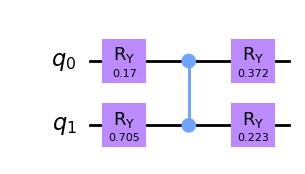

In [75]:
num_qubits = 2
num_reps = 1
num_params = 2 * num_qubits * num_reps

params = np.random.rand(num_params)

ansatz = TwoLocal(num_qubits, 'ry', 'cz', reps=num_reps, entanglement='linear')
ansatz.assign_parameters(params, inplace=True)
ansatz.decompose().draw(output='mpl')

### Encoding

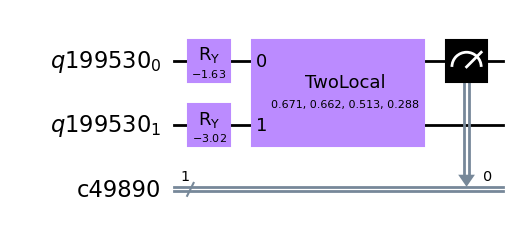

In [108]:
def angle_encoding(x):
    qc = QuantumCircuit(2)
    qc.ry(x[0], 0)
    qc.ry(x[1], 1)
    return qc


def circuit(x, params):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr, cr)

    ansatz = TwoLocal(num_qubits, 'ry', 'cz', reps=num_reps, entanglement='linear')
    ansatz.assign_parameters(params, inplace=True)
    qc.append(angle_encoding(x), qr)
    qc.append(ansatz, qr)

    qc.measure(qr[0], cr)

    return qc

circ = circuit(X_train_norm[0], params)
circ.decompose().draw(output='mpl')

### Cost Function

In [148]:
def callback(parameter, cost):
        global iteration, best_acc, best_params, history

        iteration += 1
        accuracy = accuracy_score(y_train, predict(X_train_norm, parameter))
        print(f'Epoch: {iteration}| Loss: {cost}, Accuracy: {accuracy}')

        history.append([iteration, cost, accuracy])

        if accuracy > best_acc:
            best_acc = accuracy
            best_params = parameter

def cost_function(X, Y, params):
    cost = 0.0
    for i, x in enumerate(X):
        y = Y[i]

        qc = circuit(x, params)

        counts = execute_circuit(qc, shots=1024)
        probs = count_to_prob(counts)

        f = probs[0] if y == 0 else probs[1]
        cost += (1 - f)**2

    cost /= len(X)
    callback(params, cost)

    return cost


def predict_single(x, params):
    qc = circuit(x, params)

    counts = execute_circuit(qc, shots=1024)
    probs = count_to_prob(counts)

    return 0 if probs[0] > probs[1] else 1

def predict(X, params):

    y_pred = []
    for i, x in enumerate(X):
        y_pred.append(predict_single(x, params))

    return np.array(y_pred)


### Train

In [149]:
iteration = 0
num_qubits = 2
num_reps = 1
num_params = num_qubits * num_reps + num_qubits

maxiter = 10

history = []

params = np.random.rand(num_params)
best_params = params
optimizer = COBYLA(maxiter=maxiter)

best_acc = accuracy_score(y_train, predict(X_train_norm, params))


cost = lambda params: cost_function(X_train_norm, y_train, params)
res = optimizer.minimize(cost, x0=params, bounds=[(0, 2*np.pi)]*num_params)

print('Accuracy:', accuracy_score(y_test, predict(X_test_norm, res.x)))

Epoch: 1| Loss: 0.09627149105072022, Accuracy: 0.9125
Epoch: 2| Loss: 0.015358161926269532, Accuracy: 1.0
Epoch: 3| Loss: 0.018635368347167967, Accuracy: 0.9875
Epoch: 4| Loss: 0.1413772463798523, Accuracy: 0.8875
Epoch: 5| Loss: 0.01512836217880249, Accuracy: 1.0
Epoch: 6| Loss: 0.10206520557403564, Accuracy: 0.95
Epoch: 7| Loss: 0.01571401357650757, Accuracy: 0.9875
Epoch: 8| Loss: 0.01346968412399292, Accuracy: 1.0
Epoch: 9| Loss: 0.043726110458374025, Accuracy: 0.9875
Epoch: 10| Loss: 0.014953804016113282, Accuracy: 1.0
Accuracy: 1.0


In [150]:
predict_train = predict(X_train_norm, best_params)
accuracy = accuracy_score(y_train, predict_train)
print('Accuracy:', accuracy)

predict_test = predict(X_test_norm, best_params)
accuracy = accuracy_score(y_test, predict_test)
print('Accuracy:', accuracy)

Accuracy: 1.0
Accuracy: 1.0


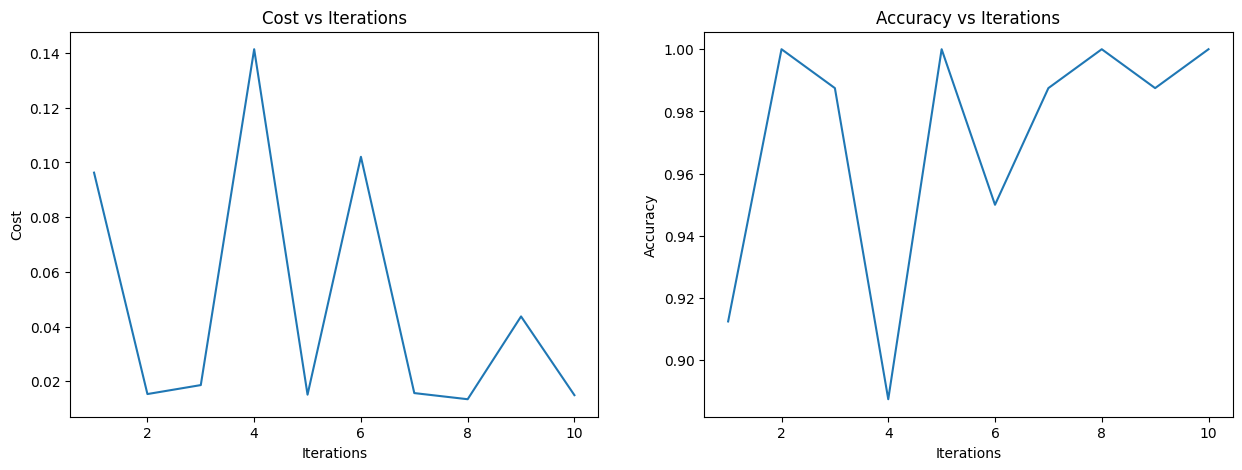

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot([x[0] for x in history], [x[1] for x in history])
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Cost')
ax[0].set_title('Cost vs Iterations')

ax[1].plot([x[0] for x in history], [x[2] for x in history])
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy vs Iterations')

plt.show()